<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Projects/Cassava_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Mar 29 06:10:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get helper function 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import the packages we need 
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import plot_loss_curves , compare_historys 

--2021-03-29 06:10:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9304 (9.1K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-03-29 06:10:05 (42.6 MB/s) - ‘helper_functions.py’ saved [9304/9304]



In [3]:
# Get tensorflow datasets 
import tensorflow_datasets as tfds

In [4]:
# Let's list the available datasets 
datasets_list = tfds.list_builders() # Gets all available datasets 
datasets_list # Prints a list of datasets 

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [5]:
# Now we want Cassava datasets, let's check if it exists there 
print(f'cassava' in datasets_list)

True


In [6]:
# Load in the data 

(train_data , test_data) , ds_info = tfds.load(name = 'cassava' , 
                                               split = ['train' , 'validation'] , 
                                               shuffle_files = True , 
                                               as_supervised = True , 
                                               with_info = True)

Shuffling and writing examples to /root/tensorflow_datasets/cassava/0.1.0.incomplete0WK6EJ/cassava-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cassava/0.1.0.incomplete0WK6EJ/cassava-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cassava/0.1.0.incomplete0WK6EJ/cassava-validation.tfrecord


Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [7]:
# Features 
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [8]:
# Getting the class names 
class_names = ds_info.features['label'].names
class_names

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

#### Using Mixed Precision 
Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.



In [9]:
# Setting mixed-precision 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [10]:
# Take one sample off the training data 
train_one_sample = train_data.take(1) # (image_tensor , label)

In [11]:
# How does it look like? 
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
# What's in our train_one_sample 
for image , label in train_one_sample:
  print(f'''
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Cassava (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
  ''')


    Image shape: (500, 666, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Cassava (tensor form): 3
    Class name (str form): cmd
  


In [13]:
# How does a image tensor looks like? 
image

<tf.Tensor: shape=(500, 666, 3), dtype=uint8, numpy=
array([[[80, 52, 48],
        [80, 52, 48],
        [78, 50, 46],
        ...,
        [39, 21, 37],
        [37, 15, 38],
        [44, 21, 49]],

       [[77, 49, 45],
        [77, 49, 45],
        [78, 50, 46],
        ...,
        [44, 27, 37],
        [31, 12, 31],
        [35, 16, 36]],

       [[80, 52, 49],
        [78, 50, 47],
        [84, 56, 52],
        ...,
        [36, 22, 22],
        [58, 43, 48],
        [72, 57, 64]],

       ...,

       [[58, 26, 27],
        [60, 28, 29],
        [63, 31, 32],
        ...,
        [49, 21, 33],
        [43, 16, 25],
        [42, 15, 24]],

       [[67, 35, 36],
        [69, 37, 38],
        [70, 38, 39],
        ...,
        [53, 25, 37],
        [43, 16, 25],
        [42, 15, 24]],

       [[72, 40, 41],
        [74, 42, 43],
        [74, 42, 43],
        ...,
        [53, 25, 37],
        [46, 19, 28],
        [46, 19, 28]]], dtype=uint8)>

In [14]:
# What's the min and max value? 
tf.reduce_min(image) , tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 665.5, 499.5, -0.5)

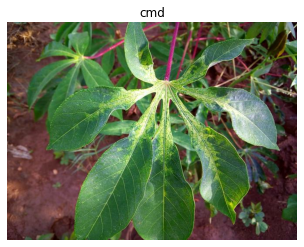

In [15]:
# Plotting an imgae from TensorFlow Datasets 
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [16]:
# Make a function for preprocessing 
def preprocess_img(image , label , img_shape = 224):
  '''
  Converts image datatype from `uint8` --> `float32` and reshapes image to 
  [image_shape , image_shape , color_channels]
  '''

  # Reshape's image
  image = tf.image.resize(images = image , 
                          size = [img_shape , img_shape])
  
  return (tf.cast(image , tf.float32) , label)

In [17]:
# After converting & Befor conversion
print(f'Before conversion: {image.shape}') 
print(f'After conversion: {tf.image.resize(image , size = [224 , 224]).shape}') 

Before conversion: (500, 666, 3)
After conversion: (224, 224, 3)


In [18]:
# Preprocess a single sample image and check the outputs 
preprocessed_img = preprocess_img(image , label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 78.15179  ,  50.151787 ,  46.151787 ],
        [ 97.79991  ,  69.79991  ,  65.79991  ],
        [ 91.3339   ,  66.3339   ,  61.3339   ],
        ...,
        [ 43.361755 ,  25.843815 ,  21.8775   ],
        [ 73.476295 ,  56.330616 ,  57.961983 ],
        [ 33.37275  ,  13.215807 ,  33.785572 ]],

       [[ 83.104706 ,  55.104713 ,  52.104713 ],
        [103.24466  ,  78.12413  ,  73.16431  ],
        [ 90.40474  ,  65.40474  ,  60.404736 ],
        ...,
        [ 22.040087 ,   9.496439 ,  15.036029 ],
        [ 15.530373 ,   5.7373276,   5.294181 ],
        [ 18.67499  ,   8.764276 ,   7.7739034]],

       [[ 83.46213  ,  58.54249  ,  54.703205 ],
        [ 92.06943  ,  67.14979  ,  63.156246 ],
        [ 83.2555   ,  58.2555   ,  53.2555   ],
        ...,
        [  7.39828  ,   1.4090507,  13.741455 ],
        [  6.725616 ,   4.8091187,   0.       ],
        [113.4843   , 112.72537  ,  81.243225 ]],

       ...,

     

(-0.5, 223.5, 223.5, -0.5)

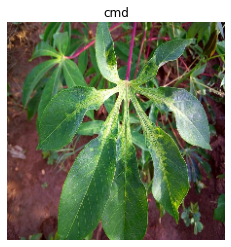

In [19]:
# Plotting our preprocessed image 
plt.imshow(preprocessed_img / 255.)
plt.title(class_names[label])
plt.axis(False)

In [20]:
# Map preprocessing function training data (and paraelellize)
train_data = train_data.map(map_func= preprocess_img , num_parallel_calls= tf.data.AUTOTUNE)
# Shuffle the dataset and turn into batches and prefetch (it loads faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map processing function testing data 
test_data = test_data.map(map_func = preprocess_img , num_parallel_calls= tf.data.AUTOTUNE)
# Turn into batches and prefect it (no shuffling)
test_data = test_data.batch(batch_size= 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
# Let's check how our preprocessed data looks like 
train_data , test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [22]:
# Creating a model checkpoint callback 
checkpoint_path = 'model_checkpoints/cp.ckpt' # Saving weights need .ckpt extension 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path , 
                                                      monitor = 'val_accuracy' , 
                                                      save_best_only = True , 
                                                      save_weights_only = True , 
                                                      verbose = 1)

## Modelling 

### Build a Feature Extraction Model 
Recall, the typical order for using transfer learning is:

- Build a feature extraction model (replace the top few layers of a pretrained model)
- Train for a few epochs with lower layers frozen
- Fine-tune if necessary with multiple layers unfrozen


In [64]:
# Trying out data augmentation layer
from tensorflow.keras.layers.experimental import preprocessing 

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip(),
  preprocessing.RandomHeight(0.3), 
  preprocessing.RandomWidth(0.3) , 
  preprocessing.RandomZoom(0.2)
])

In [65]:
from tensorflow.keras import layers 

# Create the base model 
input_shape = (224 , 224 , 3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False # Freeze all the layers 

# Create a Functional model 
inputs = layers.Input(shape = input_shape , name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x , training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names) , name = 'output_layer')(x)
# Separate activation function so we can output float32 activations
outputs = layers.Activation(activation='softmax' , dtype = tf.float32 , name = 'softmax_float32')(x)

# Packing into a model 
model = tf.keras.Model(inputs , outputs)

# Checking the summary of the model 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
_________________________________________________________________
softmax_float32 (Activation) (None, 5)                 0         
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_____________________________________________

In [66]:
# Compile the model 
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = ['accuracy'])

### Checking layer dtype policies (are we using mixed precision?

We know that mixed precision API will automatically to whatever the gloabl dtype policy is (in our case it's `mixed_float16`

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype.policy`

In [67]:
# Check the dtype policy attributes of layers in our model 
for layer in model.layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
sequential_1 True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


> **🔑 Note:** A layer can have a dtype of **float32** and a dtype policy of **"mixed_float16"** because it stores its variables (weights & biases) in float32 (more numerically stable), however it computes in float16 (faster).



In [68]:
# Now checking the layers in our base model (EfficientNet_B0)
for layer in base_model.layers[:20]: 
  print(layer.name ,layer.trainable, layer.dtype , layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float

In [69]:
# Fit the model with callbacks (feature extraction model)
history_feature_extraction_model = model.fit(train_data , 
                                                     epochs = 3 , 
                                                     steps_per_epoch = len(train_data) , 
                                                     validation_data = test_data , 
                                                     validation_steps = int(0.25 *len(test_data) ), 

                                                     callbacks = [model_checkpoint])

Epoch 1/3
177/177 [==============================] - 69s 332ms/step - loss: 1.1000 - accuracy: 0.5907 - val_loss: 0.7962 - val_accuracy: 0.7188

Epoch 00001: val_accuracy did not improve from 0.74792
Epoch 2/3
177/177 [==============================] - 58s 310ms/step - loss: 0.8116 - accuracy: 0.7074 - val_loss: 0.7204 - val_accuracy: 0.7312

Epoch 00002: val_accuracy did not improve from 0.74792
Epoch 3/3
177/177 [==============================] - 52s 278ms/step - loss: 0.7367 - accuracy: 0.7296 - val_loss: 0.6870 - val_accuracy: 0.7625

Epoch 00003: val_accuracy improved from 0.74792 to 0.76250, saving model to model_checkpoints/cp.ckpt


In [70]:
# Evaluating on the whole dataset 
results_feature_extract_model = model.evaluate(test_data)

60/60 [==============================] - 6s 101ms/step - loss: 0.7298 - accuracy: 0.7448


### Load and evaluate checkpoint weights 

We can load in and evaluate our model's checkpoints by: 
- Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights. 
- Calling the `load_weights()` method on cloned model passing it the path to where our checkpointed weights are storied. 
- Calling `evaluate()` on the cloned model with loaded weight .

> A reminder, checkpoints are helpful for when you perform an experiment such as **fine-tuning your model**. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [30]:
# Cloning the model, which doesn't perform like the original one (reset weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
_________________________________________________________________
softmax_float32 (Activation) (None, 5)                 0         
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_______________________________________________

In [31]:
# Original model summary 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 6405      
_________________________________________________________________
softmax_float32 (Activation) (None, 5)                 0         
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_______________________________________________

Looks fishy right? Eventhough the parameters are all same, but the weights or patterns learned by the model is way more different.

**What can we do now to get this cloned model to work like our previous one?**

Well few cells before we created a **`ModelCheckpoint`** callback called `model_checkpoint` which has all our weights stored in it. We can load this to our model and re-create the previous model with same performance.

In [34]:
# Where our model checkpoint is stored
checkpoint_path

'model_checkpoints/cp.ckpt'

In [33]:
# Loading the weights into our cloned model 
cloned_model.load_weights(checkpoint_path)

Each time when you make a change to your mode, you have to re-compile it. 

In [52]:
# Re-compiling the cloned model 
base_lr = 0.001
cloned_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(lr = base_lr/10) , 
                     metrics = ['accuracy'])

Alrighty, after re-compiling our model let's evaluate the model. To ensure if it works same like the previous model the resutls should be equal to the original model.

In [36]:
# Evaluating with the cloned model 
results_cloned_model = cloned_model.evaluate(test_data)

60/60 [==============================] - 9s 98ms/step - loss: 0.7790 - accuracy: 0.7252


In [37]:
# Our original model 
results_feature_extract_model

[0.7684352397918701, 0.7300158739089966]

In [47]:
# Check the base_model in cloned_odel and see what dtype policy they're using 
for layer in cloned_model.layers[2].layers[:20]:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

Alright now everything's done it's time to Fine_Tune the model 

### Fine-tuning 

In [71]:
# Freezing all the layer 
base_model.trainable = True 

# Freeze all layers except for the last 5 layers 
for layer in base_model.layers[:-10]:
  layer.trainable = False 

# Re-compile the model 
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
              optimizer = tf.keras.optimizers.Adam(lr = base_lr / 10) , 
              metrics = ['accuracy'])

In [72]:
# Are any of the layers in our model is frozen ? 
for layer in model.layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
sequential_1 True float32 <Policy "mixed_float16">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [73]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Gonna just fine-tune without any other callbacks at first, then will work on these two callbacks which I haven't worked on it yet before: 
- `EarlyStopping` Callback
- `ReduceLROnPlateau` Callback



In [74]:
# Let's fine tune for 5 epochs
initial_epochs = 3 
fine_tune_epochs = initial_epochs + 15

history_fine_tune_model_cassva = model.fit(train_data , 
                                           epochs = fine_tune_epochs , 
                                           validation_data = test_data , 
                                           validation_steps = int(0.25 * len(test_data)) , 
                                           initial_epoch = history_feature_extraction_model.epoch[-1] )

Epoch 3/18
177/177 [==============================] - 60s 278ms/step - loss: 0.6981 - accuracy: 0.7439 - val_loss: 0.7026 - val_accuracy: 0.7500
Epoch 4/18
177/177 [==============================] - 50s 263ms/step - loss: 0.6697 - accuracy: 0.7599 - val_loss: 0.6738 - val_accuracy: 0.7688
Epoch 5/18
177/177 [==============================] - 52s 274ms/step - loss: 0.6369 - accuracy: 0.7715 - val_loss: 0.6565 - val_accuracy: 0.7750
Epoch 6/18
177/177 [==============================] - 46s 246ms/step - loss: 0.5937 - accuracy: 0.7879 - val_loss: 0.6058 - val_accuracy: 0.7958
Epoch 7/18
177/177 [==============================] - 42s 221ms/step - loss: 0.5677 - accuracy: 0.8023 - val_loss: 0.6249 - val_accuracy: 0.7854
Epoch 8/18
177/177 [==============================] - 41s 214ms/step - loss: 0.5493 - accuracy: 0.8096 - val_loss: 0.5700 - val_accuracy: 0.7958
Epoch 9/18
177/177 [==============================] - 40s 209ms/step - loss: 0.5527 - accuracy: 0.8005 - val_loss: 0.6595 - val_ac

In [75]:
results_fine_tune_model = model.evaluate(test_data)

60/60 [==============================] - 6s 100ms/step - loss: 0.6688 - accuracy: 0.7570
